In [ ]:
%run viz_common.py

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
import FinanceDataReader as fdr

In [3]:
df = fdr.DataReader("233740","2010")
df.columns = ['open','high','low','close','volume', 'change']

In [4]:
df.head()

,open,high,low,close,volume,change
Date,,,,,,
2015-12-17,10240,10405,9970,10330,946156,NaN
2015-12-18,10230,10710,10165,10710,1841150,0.036786
2015-12-21,10695,10825,10670,10720,1274858,0.000934
2015-12-22,10740,10750,10450,10495,1374974,-0.020989
2015-12-23,10535,10635,10415,10425,2532341,-0.006670


# 기본 계수에 의한 테스트

In [5]:
def strategy(d2, k=0.5):
    d = d2.copy()
    d.insert(len(d.columns), 'range', d['high']-d['low'])
    
    prev_range = d['range'].shift(1)
    sell_price = d['open'].shift(-1)
    buy_price = round((d['open'] + prev_range * k)/5.0)*5
    bool = d['high'] >= buy_price
    bool = bool.astype(int)
    #print(bool)
    
    daily_profit = bool * ((sell_price - buy_price) / buy_price - 0.15/100)
    d['profit'] = np.nan
    k = len(d.columns) - 1
    d.iloc[0,k] = 1  #여기서 d['profit'][0]로 하면 SettingWithCopyWarning이 뜸
    for i in range(1,len(d['profit'])):
        d.iloc[i,k] = d.iloc[i-1,k] * (1 + daily_profit[i]) # 여기도
    d = d.dropna()
    resultdf = [d['profit'], daily_profit]
    return resultdf

In [6]:
import cagr_mdd as cm
from tqdm import tqdm_notebook as tn

In [8]:
cagr = []; mdd= []; index=[]

for i in tn(np.arange(0.1, 1.05, 0.05)):
    c, m = cm.result(strategy(df, i)[0])
    cagr.append(c); mdd.append(m); 
    index.append('*{}'.format(round(i*100)/100))
    
cagr2 = pd.Series(cagr, index=index)
mdd2 = pd.Series(mdd, index=index)

cagrMdd = pd.DataFrame({'CAGR':cagr2, 'MDD':mdd2})

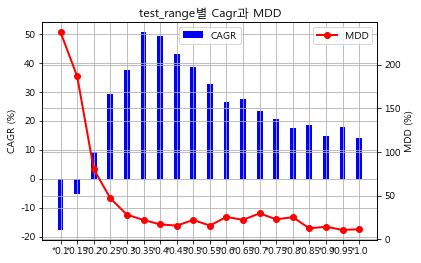

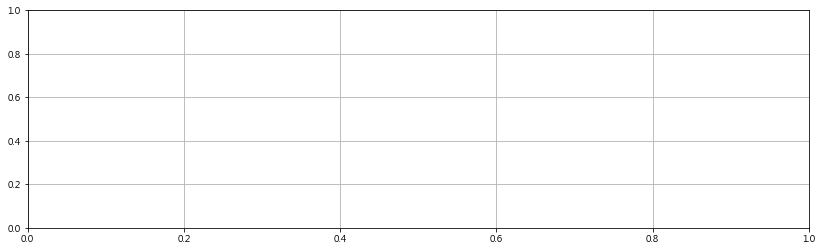

In [22]:
#이제 그래프!
plt.bar(cagrMdd.index,cagrMdd['CAGR'], 0.35, color='b', label = 'CAGR')
plt.ylabel('CAGR (%)')
plt.legend(loc='upper center')
plt.twinx()
plt.plot(cagrMdd.index, cagrMdd['MDD'], '-or', label='MDD')
plt.ylabel('MDD (%)')
plt.legend()
plt.title("test_range별 Cagr과 MDD")
plt.figure(figsize=(14,4))
plt.grid(linestyle='-')

In [ ]:
basic_profit = strategy(df, k=0.35)[1]
basic_profit = basic_profit.dropna()

In [ ]:
def get_stats(s, n=252):
    s = s.dropna()
    wins = len(s[s>0])
    losses = len(s[s<0])
    evens = len(s[s==0])
    mean_w = round(s[s>0].mean(), 3)
    mean_l = round(s[s<0].mean(), 3)
    win_r = round(wins/losses, 3)
    mean_trd = round(s.mean(), 3)
    sd = round(np.std(s), 3)
    max_l = round(s.min(), 3)
    max_w = round(s.max(), 3)
    sharpe_r = round((s.mean()/np.std(s))*np.sqrt(n), 4)
    cnt = len(s)
    print('Trades:', cnt,\
          '\nWins:', wins,\
          '\nLosses:', losses,\
          '\nBreakeven:', evens,\
          '\nWin/Loss Ratio', win_r,\
          '\nMean Win:', mean_w,\
          '\nMean Loss:', mean_l,\
          '\nMean', mean_trd,\
          '\nStd Dev:', sd,\
          '\nMax Loss:', max_l,\
          '\nMax Win:', max_w,\
          '\nSharpe Ratio:', sharpe_r)

In [ ]:
get_stats(basic_profit)

# noise 비율에 따른 테스트

In [ ]:
def strategy_noise(d2, days=3):
    d = d2.copy()
    d.insert(len(d.columns), 'range', d['high']-d['low'])
    
    prev_range = d['range'].shift(1)
    sell_price = d['open'].shift(-1)
    
    noise = 1 - abs(d['open']-d['close'])/abs(d['high']-d['low'])
    d.insert(len(d.columns), 'noise3', noise.shift(1).rolling(days).mean())
    d = d.dropna()    
    
    buy_price = round((d['open'] + prev_range * d['noise3'])/5.0)*5
    buy_price = buy_price.dropna()
    bool = d['high'] >= buy_price
    bool = bool.astype(int)
    daily_profit = bool * ((sell_price - buy_price) / buy_price - 0.15/100)
    daily_profit = daily_profit.dropna()
   
    pf = pd.Series(index=d.index)
    pf[0] = 1
    for i in range(1,len(pf)-1):
        pf[i] = pf[i-1] * (1 + daily_profit[i])
    pf = pf.dropna()
    resultddf = [pf, daily_profit]
    return resultddf

In [ ]:
cagr = []; mdd= []; index=[]

for i in range(1,21):
    c, m = cm.result(strategy_noise(df, i)[0])
    cagr.append(c); mdd.append(m); 
    index.append(i)
    
cagr2 = pd.Series(cagr, index=index)
mdd2 = pd.Series(mdd, index=index)

cagrMdd = pd.DataFrame({'CAGR':cagr2, 'MDD':mdd2})

plt.bar(cagrMdd.index,cagrMdd['CAGR'], 0.35, color='b', label = 'CAGR')
plt.ylabel('CAGR (%)')
plt.legend(loc='upper center')
#plt.ylim(50,90)
plt.xticks(range(1,21))
plt.twinx()
plt.plot(cagrMdd.index, cagrMdd['MDD'], '-or', label='MDD')
plt.ylabel('MDD (%)')
plt.legend(loc='upper left')
#plt.ylim(0,40)
plt.title("Noise 비율에 따른 cage과 MDD")
plt.figure(figsize=(14,4))

In [ ]:
cagrMdd

In [ ]:
noise_profit = strategy_noise(df, 16)[1]

In [ ]:
get_stats(noise_profit)

In [ ]:
noise_profit13 = strategy_noise(df, 13)[1]

In [ ]:
get_stats(noise_profit13)